In [107]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import csv
import json
import math
import numpy as np
from datetime import datetime
from collections import defaultdict, Counter
import plotly.graph_objs as go
import plotly.offline as pyo

In [9]:
bigfive_human_data = pd.read_csv('data/bigfive_data.csv', delimiter='\t')
bigfive_human_data['hue'] = 'Human'
bigfive_human_data.head()

,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O2,O3,O4,O5,O6,O7,O8,O9,O10,hue
0,3,53,1,1,1,1,US,4,2,5,...,1,3,1,5,1,4,2,5,5,Human
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,2,3,3,1,3,2,Human
2,1,14,2,2,1,1,PK,5,1,1,...,5,5,1,5,1,5,5,5,5,Human
3,3,19,2,2,1,1,RO,2,5,2,...,3,5,2,4,2,5,2,5,5,Human
4,11,25,2,2,1,2,US,3,1,3,...,1,1,1,3,1,3,1,5,3,Human


In [131]:
### independent 30 instances
records_gpt4 = json.load(open('records/bigfive_gpt4_2023_06_26-01_37_11_PM.json', 'r'))
records_turbo = json.load(open('records/bigfive_turbo_2023_06_26-02_06_26_AM.json', 'r'))
bigfive_model_data = {}
bigfive_model_data['gpt4'] = pd.DataFrame(records_gpt4['choices'])
bigfive_model_data['turbo'] = pd.DataFrame(records_turbo['choices'])
bigfive_model_data['gpt4']['hue'] = 'ChatGPT-4'
bigfive_model_data['turbo']['hue'] = 'ChatGPT-3'
questions = {}
with open('data/bigfive.tsv', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        questions[row[0]] = row[1]

keyed = {}
indices = defaultdict(int)
dimensions = 'EACNO'
with open('data/bigfive_IPIP.tsv', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        d = dimensions[int(row[-1][1])-1]
        v = row[-1][2]
        indices[d] += 1
        k = '%s%i' % (d, indices[d])
        keyed[k] = v
models = ['gpt4', 'turbo']
beg_pos = list(range(7, 100, 10))[:5]
# d_scores_model = defaultdict(dict)

dimensions = 'ENACO'
for i, d in enumerate(dimensions):
    
    ### human scores
    d_score = 0
    for j in range(10):
        k = '%s%i' % (d, j+1)
        v = keyed[k]
        score = bigfive_human_data.iloc[:, beg_pos[i]+j]
        if v == '-': score = 6 - score
        d_score += score
    bigfive_human_data[d] = d_score

    ### model scores
    for model in models:
        d_score = 0
        records = eval('records_%s' % model)
        for j in range(10):
            k = '%s%i' % (d, j+1)
            v = keyed[k]
            score = bigfive_model_data[model].iloc[:, i*10+j]
            # score = np.mean(records['choices'][k])
            if v == '-': score = 6 - score
            d_score += score
        # d_scores_model[model][d] = d_score
        bigfive_model_data[model][d] = d_score
data = pd.concat([
    bigfive_human_data, 
    bigfive_model_data['gpt4'], 
    bigfive_model_data['turbo']
], ignore_index=True)
data[['E', 'hue']]
data['N'] = 60 - data['N']
data[[*dimensions, 'hue']]

,E,N,A,C,O,hue
0,44,11,46,47,43,Human
1,22,31,35,42,26,Human
2,35,46,38,49,45,Human
3,22,43,37,26,41,Human
4,34,30,44,34,34,Human
...,...,...,...,...,...,...
19774,30,30,30,33,28,ChatGPT-3
19775,30,30,32,32,28,ChatGPT-3
19776,31,30,30,33,29,ChatGPT-3
19777,30,30,32,33,28,ChatGPT-3


In [112]:
# data.describe()

In [106]:
categories=['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
categories=[*dimensions]
categories = [''] * len(dimensions)
N = len(categories)
value_type = 'median'
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]
# print(angles)

df = pd.DataFrame(columns=['hue', 'E_med','N_med','A_med','C_med','O_med','E_std','N_std','A_std','C_std','O_std'])
df = pd.DataFrame(columns=['hue','dimension', 'med_value', 'std'])

for hue in hues:
    medians = data[data['hue'] == hue][[*dimensions]].agg(['median'])
    stds = data[data['hue'] == hue][[*dimensions]].agg(['std'])
    row = [hue] + medians.loc['median'].tolist() + stds.loc['std'].tolist()
    # print(stds)
    for dim, median_val in medians.loc['median'].items():
        df.loc[len(df)] = [hue] + [dim] + [median_val] + [stds.loc['std'][dim]]

print(df)

bars = alt.Chart(df).mark_bar().encode(
    x='dimension:N',
    y='med_value:Q',
    color='hue:N',
    column='hue:N'
)

bars

          hue dimension  med_value       std
0       Human         E       30.0  9.223193
1       Human         N       31.0  8.617606
2       Human         A       39.0  7.145843
3       Human         C       34.0  7.306510
4       Human         O       40.0  6.256707
5   ChatGPT-4         E       31.0  0.927857
6   ChatGPT-4         N       29.0  0.727932
7   ChatGPT-4         A       36.0  1.003442
8   ChatGPT-4         C       36.0  0.714384
9   ChatGPT-4         O       37.5  0.937102
10  ChatGPT-3         E       30.0  0.973204
11  ChatGPT-3         N       30.0  0.000000
12  ChatGPT-3         A       32.0  1.229896
13  ChatGPT-3         C       33.0  1.008014
14  ChatGPT-3         O       28.0  0.730297


alt.Chart(...)

In [126]:
categories = ['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
N = len(categories)

# Assuming data has been loaded and is available as 'data' dataframe

hues = ['Human', 'ChatGPT-4', 'ChatGPT-3']
value_type = 'median'  # or mean, etc.

# Generating the radar chart for each hue
data_trace = []
for hue in hues:
    d_scores = data[data['hue'] == hue][[*dimensions]].agg(['median', 'mean', 'std'])
    # d_scores = data[data['hue'] == hue][categories].agg(['median', 'mean', 'std'])
    values = d_scores.loc[value_type].values.tolist()
    std_dev = d_scores.loc['std'].values.tolist()
    values += values[:1]  # Repeat the first value at the end to close the radar chart
    std_dev += std_dev[:1]  # Repeat the first value at the end to ensure the error band is continuous
    
    upper_bound = np.array(values) + np.array(std_dev)
    lower_bound = np.array(values) - np.array(std_dev)
    
    upper_bound = np.array(values) + np.array(std_dev)
    lower_bound = np.array(values) - np.array(std_dev)
    
    trace = go.Scatterpolar(
        r = values,
        theta = categories,
        # fill = 'toself',
        name = hue,
        hoverinfo = 'all'
    )

    trace_upper = go.Scatterpolar(
        r=upper_bound.tolist(),
        theta=categories,
        marker=dict(color='#444'),
        line=dict(width=0),
        hoverinfo='none'
    )

    trace_lower = go.Scatterpolar(
        r=lower_bound.tolist(),
        theta=categories,
        marker= dict(color='#444'),
        fill='tonext',
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
    )
    
    # data_trace.append(trace)
    data_trace.extend([trace_upper, trace])

layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = True,
            range = [0, 50]
        )
    ),
    showlegend = True
)

fig = go.Figure(data=data_trace, layout=layout)
pyo.plot(fig)

'temp-plot.html'

[30. 31. 39. 34. 40.] [18.44638655 17.23521204 14.29168605 14.613021   12.5134136 ]
[31.  29.  36.  36.  37.5] [1.855715   1.45586408 2.0068847  1.42876846 1.87420481]
[30. 30. 32. 33. 28.] [1.94640842 0.         2.4597916  2.01602773 1.46059349]


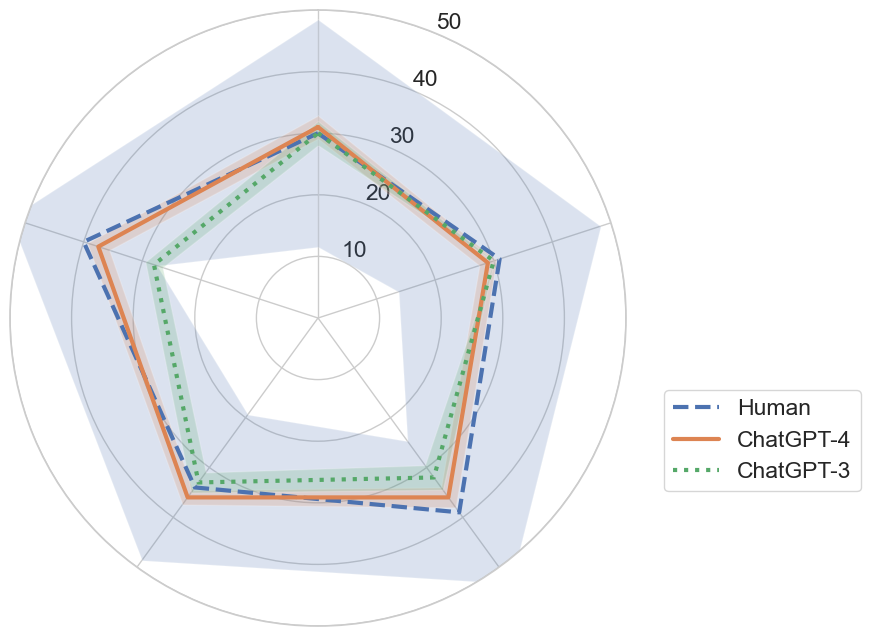

In [23]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

categories=['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
categories=[*dimensions]
categories = [''] * len(dimensions)
N = len(categories)
value_type = 'median'
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

hues = ['Human', 'ChatGPT-4', 'ChatGPT-3']
hue2line = {
    'Human': '--',
    'ChatGPT-4': '-',
    'ChatGPT-3': ':',
}
for hue in hues:
    d_scores = data[data['hue'] == hue][[*dimensions]].agg(['median', 'mean', 'std'])
    values = np.array(d_scores.loc[value_type])
    errors = np.array(d_scores.loc['std']) * 2
    print(values, errors)
    values = np.concatenate((values, [values[0]]))  # Close the plot
    errors = np.concatenate((errors, [errors[0]]))  # Close the plot

    ax.fill_between(angles, values - errors, values + errors, alpha=0.2)
    ax.plot(angles, values, linestyle=hue2line[hue], linewidth=3, label=hue)
 
plt.xticks(angles[:-1], categories)
# ax.set_rlabel_position(0)
plt.ylim(0,50)
plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.2))
# plt.savefig('figures/cmp-bigfive.pdf', format='pdf', bbox_inches='tight')
plt.show()